<a href="https://colab.research.google.com/github/ssumin6/cs470/blob/master/CS470_Assignment_2_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS470 Assignment #2: Neural Style Transfer

Primary TA: Hyunsu Kim

TA's E-mail: khszone02@kaist.ac.kr

## Instruction
- There are total **two models** for the neural style transfer in this homework.
- Fill in the code blocks enveloped with some comments
- Refer to [the neural style transfer paper](https://arxiv.org/pdf/1508.06576.pdf) or the lecture slide for the first neural style transfer model.
- Refer to [the fast neural style transfer paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) or the lecture slide for the second neural style transfer model.
- There are total **10 problems**. Only the last problem (10) is for the second model. You have to start the **problem 10** as soon as possible if you want to get a score for the second model (20%). **It will take lots of time** in aspects of both coding and learning times.

## Submission guidelines
- *(The first and second model)* **Don't revise the codes except the commented blocks when you submit this notebook.**
- *(The second model)* The TAs should be able to reproduce your results using your code and pre-trained model. **Please double-check if your code runs without error and loads your pre-trained model properly.** Submissions failed to run or reproduce the results will get a substantial penalty.

## Deliverables
- Download your **Notebook file (*for the first and second model*)**, **style/content/synthsized images (*for the first and second model*)**, and the **checkpoints (*only for the second model*)**, and submit a zip file in a format: [StudentID].zip. Please double-check that you locate and load your pre-trained model (checkpoints) properly.
- Your assignment should be submitted through **KLMS**. All other submissions (e.g., via email) will not be considered as valid submissions.

## Grading policy
- **Code** (100%): The filled code blocks should work well. **Each problem occupies some points** so that you get a score if you write appropriate code logic even though the model doesn't work.
  - **The first model** (80%): Step 1-8
  - **The second model** (20%): Step 9 (will be taken lots of time)
- **Result** (Extra points): Extra points will be given if you generated a **naturally** synthesized image. If you generate an awful image such as so noisy image, an image that the style is not similar to the style image and so on. You should tune the hyperparameters to improve the image quality.

## Due date
Midnight October 30

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 2]" in the subject for all questions regarding this assignment (e.g., [Assignment 2] Regarding the grading policy).

## PyTorch Documentation
- You can refer PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html

## Step 0: Connect to Google drive

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 1: Import modules

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms  # transform PIL images into tensors
import torchvision.models as models  # train or load pre-trained models
from torchvision import datasets

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Download images
Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions.

**Problem 1.** Pick images to merge. The style image should be an western painting (no margin).

In [0]:
import urllib

##########################################################################
#### TODO: Download images to merge.                                  ####
####       The style image should be an western painting (no margin). ####
##########################################################################

# revise only image URLs
urllib.request.urlretrieve("https://www.pablopicasso.org/images/paintings/reading.jpg", "style.jpg")
urllib.request.urlretrieve("https://cdn.images.express.co.uk/img/dynamic/36/590x/Joaquin-Phoenix-as-Joker-in-new-DC-movie-Joker-1185726.jpg?r=1570557109810", "content.jpg")

##########################################################################

!ls style.jpg content.jpg

content.jpg  style.jpg


In [0]:
imsize = 256

preprocess = transforms.Compose([
  transforms.Resize(imsize),            # fixed size for both content and style images
  transforms.CenterCrop(imsize),        # crops the given PIL Image at the center.
  transforms.ToTensor(),                # range between 0 and 1
])

In [0]:
# A PIL image to a Tensor
def image_loader(image_name, batch_size=None):
  image = Image.open(image_name)
  image = preprocess(image)
  if batch_size is None:
    image = image.unsqueeze(0)      # fake batch dimension for the pre-trained model input.
  else:
    image = image.repeat(batch_size, 1, 1, 1)

  return image.to(device, torch.float)

In [0]:
# A Tensor to a PIL image
def imshow(tensor, title=None, save=None):
  unloader = transforms.ToPILImage()
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  if save:
    image.save(save)

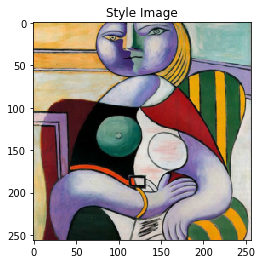

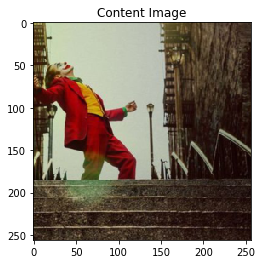

In [0]:
style_img = image_loader("./style.jpg")
content_img = image_loader("./content.jpg")

plt.ion()

plt.figure()
imshow(style_img, title='Style Image', save=gdrive_data+'/style.jpg')  # save at Google drive my_data directory

plt.figure()
imshow(content_img, title='Content Image', save=gdrive_data+'/content.jpg')

## Step 3: Preload the pre-trained model
Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper. PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 55.4MB/s]


## Step 4: Define the loss functions

$$P^* = \underset{P}{\mathrm{argmin}}\ \mathcal{L}_{content}(P, X) + \lambda\mathcal{L}_{style}(P, Y)$$
P is an input image, X is a content image, and Y is a style image.
### Content Loss
$$\mathcal{L}_{content}(P, X) = \sum_l\sum_{i, j}w_l\biggr(F_{i,j}^{X,l} - F_{i,j}^{P,l}\biggr)^2$$
l is the layer, F_ij is a ith row and jth column of a feature, and w is a weight.

**Problem 2.** Define the content loss for a layer. Don't regard weights, which is computed inside the optimization.

In [0]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()  # the feature tensor of the content image

  def forward(self, input):
    ################################################################################
    #### TODO: Define the content loss for a layer.                             ####
    ####       Don't regard weights, which is computed inside the optimization. ####
    #### Input:                                                                 ####
    ####   - input: the feature tensors of (a, b, c, d) size, where             ####
    ####            a = batch size (= 1)                                        ####
    ####            b = number of feature maps                                  ####
    ####            (c, d) = dimensions of a feature map (N=c*d)                ####
    #### Output:                                                                ####
    ####   - input                                                              ####
    ################################################################################

    # used mean square error loss
    self.loss = F.mse_loss(input, self.target)
    ################################################################################
    return input

### Style Loss
$$\mathcal{L}_{style}(P, Y) = \sum_l\sum_{i, j}w_l\biggr(G_{i,j}^{Y,l} - G_{i,j}^{P,l}\biggr)^2$$
$$\mathrm{(Gram\ matrix)}\ G = F^TF$$
l is the layer, G_ij is a ith row and jth column of a gram matrix, and w is a weight.

**Problem 3.** Define the gram matrix.

In [0]:
def gram_matrix(input):
  ################################################################################
  #### TODO: Define the gram matrix.                                          ####
  #### Input:                                                                 ####
  ####   - input: the feature tensors of (a, b, c, d) size, where             ####
  ####            a = batch size (= 1)                                        ####
  ####            b = number of feature maps                                  ####
  ####            (c, d) = dimensions of a feature map (N=c*d)                ####
  #### Output:                                                                ####
  ####   - G: the gram matrix of (b, b) size                                  ####
  ################################################################################

  a, b, c, d = input.size()
  input = input.view(a*b, -1)

  G = torch.mm(input, input.t())

  G = G.div(b*c*d)

  ################################################################################
  return G

**Problem 4.** Define the style loss for a layer with the gram matrix. Don't regard weights, which is computed inside the optimization.

In [0]:
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = target.detach()  # the feature tensor of the style image

  def forward(self, input):
    ################################################################################
    #### TODO: Define the style loss for a layer with the gram matrix.          ####
    ####       Don't regard weights, which is computed inside the optimization. ####
    #### Input:                                                                 ####
    ####   - input: the feature tensors of (a, b, c, d) size, where             ####
    ####            a = batch size (= 1)                                        ####
    ####            b = number of feature maps                                  ####
    ####            (c, d) = dimensions of a feature map (N=c*d)                ####
    #### Output:                                                                ####
    ####   - input                                                              ####
    ################################################################################

    G_input = gram_matrix(input)
    G_target = gram_matrix(self.target)

    #used mean square error loss
    self.loss = F.mse_loss(G_input, G_target)
    
    ################################################################################
    return input

## Step 5: Transfer model

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [0]:
class NormalizationLayer(nn.Module):
  def __init__(self, mean, std):
    super(NormalizationLayer, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting.

**Problem 5.** Decide on which layers to compute the content loss and the style loss.

In [0]:
######################################################################################
#### TODO: Decide on which layers to compute the content loss and the style loss. ####
######################################################################################

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

######################################################################################

In [0]:
def transfer_model(cnn, style_img, content_img):
  
  # import the pre-trained model
  cnn = copy.deepcopy(cnn)
  
  # initialize the transfer model with a normalization layer first
  normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  model = nn.Sequential(NormalizationLayer(normalization_mean, normalization_std).to(device))

  content_losses = []
  style_losses = []
  # stack the cnn layers on the transfer model
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      name = f"relu_{i}"
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
      name = f"bn_{i}"
    else:
      raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")
    
    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module(f"content_loss_{i}", content_loss)
      content_losses.append(content_loss)
    
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module(f"style_loss_{i}", style_loss);
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
      
  model = model[:(i + 1)]

  return model, style_losses, content_losses

## Step 6: Define the style transfer

We will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content and style losses.

In [0]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the model and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [0]:
def merge_image(cnn, content_img, style_img, input_img,
                num_steps, style_weight, content_weight):

  # get a transfer model
  model, style_losses, content_losses = transfer_model(cnn, style_img, content_img)

  # get an optimizer
  output_img = input_img.clone()
  optimizer = get_input_optimizer(output_img)

  # start optimizing
  run = [0]
  while run[0] <= num_steps:
    def closure():
      output_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(output_img)
      style_score = 0
      content_score = 0
      for i, sl in enumerate(style_losses):
        style_score += style_weight[i] * sl.loss
      for j, cl in enumerate(content_losses):
        content_score += content_weight[j] * cl.loss

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print(f"run {run}:")
        print(f"Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f}")
        print()

      return style_score + content_score

    optimizer.step(closure)

  output_img.data.clamp_(0, 1)

  del model
  return output_img.cpu()

## Step 7: Run the style transfer
**Problem 6 (Optional).** Revise the hyperparameters if you need.

In [0]:
###########################################################
#### TODO: Revise the hyperparameters if you need.     ####
###########################################################
NUM_STEPS = 300
STYLE_WEIGHTS = [100000, 100000, 100000, 100000, 100000]
CONTENT_WEIGHTS = [1]

assert len(STYLE_WEIGHTS) == len(style_layers) and len(CONTENT_WEIGHTS) == len(content_layers), \
    "we need to set the number of weights equal to the number of the style and content losses"
###########################################################

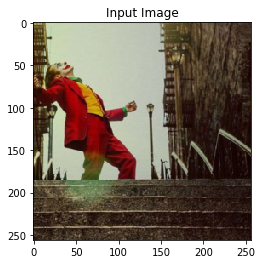

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


run [50]:
Style Loss: 24.624964 Content Loss: 19.347494

run [100]:
Style Loss: 10.002898 Content Loss: 18.417479

run [150]:
Style Loss: 5.802998 Content Loss: 17.400082

run [200]:
Style Loss: 4.502981 Content Loss: 16.654547

run [250]:
Style Loss: 3.898394 Content Loss: 16.196541

run [300]:
Style Loss: 4.557654 Content Loss: 15.895338



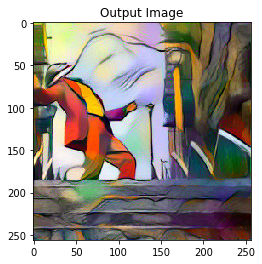

In [0]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

output_img = merge_image(cnn, content_img, style_img, input_img,
                         NUM_STEPS, STYLE_WEIGHTS, CONTENT_WEIGHTS)

plt.figure()
imshow(output_img, title='Output Image', save=gdrive_data+'/baseline.jpg')

plt.ioff()
plt.show()

## Step 8: Improve the model with the total-variation regularization
$$\mathcal{L}_{total-variation} = w\sum_{c=1}^3\biggr(\sum_{i=1}^{H}\sum_{j=1}^{W-1}(x_{i,j+1,c} - x_{i,j,c})^2 + \sum_{i=1}^{H-1}\sum_{j=1}^{W}(x_{i+1,j,c}-x_{i,j,c})^2\biggr)$$
c is RGB, x_ijc is an element of input image tensor, and (H, W) is a size of an input image.

**Problem 7.** Define the total-variation loss.

In [0]:
class TotalVariationLoss(nn.Module):
  def __init__(self):
    super(TotalVariationLoss, self).__init__()

  def forward(self, input):
    ################################################################################
    #### TODO: Define the total-variation loss.                                 ####
    #### Input:                                                                 ####
    ####   - input: the image tensors of (a, b, c, d) size, where               ####
    ####            a = batch size (= 1)                                        ####
    ####            b = RGB (= 3)                                               ####
    ####            (c, d) = size of the input image                            ####
    #### Output:                                                                ####
    ####   - input                                                              ####
    ################################################################################

    #use mean square error loss.
    self.loss = F.mse_loss(input[:,:,:,1:], input[:,:,:,:-1])+F.mse_loss(input[:,:,1:,:], input[:,:,:-1,:])
    
    ################################################################################
    return input

**Problem 8.** Define a new merg_image function regarding the total-variation loss.

In [0]:
def merge_image_with_tv_loss(cnn, content_img, style_img, input_img,
                num_steps, style_weight, content_weight, tv_weight):
  
  # get a transfer model
  old_model, style_losses, content_losses = transfer_model(cnn, style_img, content_img)
  tv_loss = TotalVariationLoss()
  model = nn.Sequential(tv_loss, *old_model)  # add the total-variation loss in the beginning of the model

  #####################################################################################
  #### TODO: Define a new merg_image function regarding the totoal-variation loss. ####
  #####################################################################################

  # get an optimizer
  output_img = input_img.clone()
  optimizer = get_input_optimizer(output_img)

  # start optimizing
  run = [0]
  while run[0] <= num_steps:
    def closure():
      output_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(output_img)
      style_score = 0
      content_score = 0
      for i, sl in enumerate(style_losses):
        style_score += style_weight[i] * sl.loss
      for j, cl in enumerate(content_losses):
        content_score += content_weight[j] * cl.loss
      tv_score = tv_weight * tv_loss.loss

      loss = style_score + content_score + tv_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print(f"run {run}:")
        print(f"Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f} TV Loss : {tv_score.item():4f}")

      return style_score + content_score + tv_score

    optimizer.step(closure)

  output_img.data.clamp_(0, 1)

  ####################################################################################
  del model
  del old_model
  return output_img.cpu()

**Problem 9 (Optional).** Revise the hyperparameters if you need.

In [0]:
#######################################################
#### TODO: Revise the hyperparameters if you need. ####
#######################################################
TV_WEIGHT = 1000
#######################################################

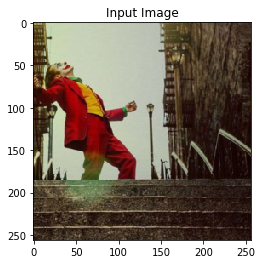

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


run [50]:
Style Loss: 23.471375 Content Loss: 19.302513 TV Loss : 13.316438
run [100]:
Style Loss: 9.437341 Content Loss: 18.682585 TV Loss : 12.792336
run [150]:
Style Loss: 6.057372 Content Loss: 17.819677 TV Loss : 12.084418
run [200]:
Style Loss: 4.977875 Content Loss: 17.217592 TV Loss : 11.871146
run [250]:
Style Loss: 4.474608 Content Loss: 17.267660 TV Loss : 11.910681
run [300]:
Style Loss: 3.760309 Content Loss: 17.045784 TV Loss : 11.883792


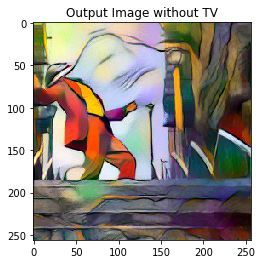

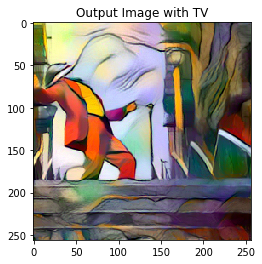

In [0]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

output_img2 = merge_image_with_tv_loss(cnn, content_img, style_img, input_img,
                                      NUM_STEPS, STYLE_WEIGHTS, CONTENT_WEIGHTS, TV_WEIGHT)

plt.figure()
imshow(output_img, title='Output Image without TV')
imshow(output_img2, title='Output Image with TV', save=gdrive_data+'/tv_loss.jpg')

plt.show()

## Step 9: Fast neural style transfer with perceptual loss.
Refer to the paper, [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)

The previous neural style transfer model merged the content and style images through the optimization so that we had to retrain if the content image is changed.

In this paper, the authors suggested a method that exploits an input image passed through a network called Image Transform Net.
![Fast neural style transfer](https://hoya012.github.io/assets/img/fast_style_transfer/1.PNG)

### Download the COCO dataset

In [0]:
import os
import urllib
import zipfile

if os.path.isdir("./val2017"):
  print("Dataset is already downloaded")
else:
  urllib.request.urlretrieve("http://images.cocodataset.org/zips/val2017.zip", "val2017.zip")
  val2017 = zipfile.ZipFile('./val2017.zip')
  val2017.extractall('.')
  val2017.close()
  print("COCO dataset is downloaded")

COCO dataset is downloaded


### Load the dataset

In [0]:
BATCH_SIZE = 4

In [0]:
train_dataset = datasets.ImageFolder(".", preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

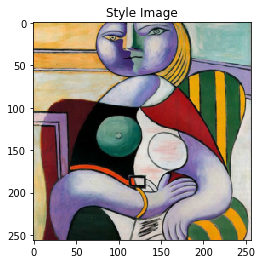

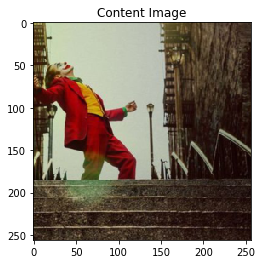

In [0]:
style_img = image_loader("./style.jpg", batch_size=BATCH_SIZE)
content_img = image_loader("./content.jpg", batch_size=BATCH_SIZE)

plt.figure()
imshow(style_img[0], title='Style Image')

plt.figure()
imshow(content_img[0], title='Content Image')

### Define the Image Transform Net

In [0]:
class ConvLayer(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super(ConvLayer, self).__init__()
    reflection_padding = kernel_size // 2
    self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

  def forward(self, x):
    out = self.reflection_pad(x)
    out = self.conv2d(out)
    return out

In [0]:
class ResidualBlock(nn.Module):
  """ResidualBlock
  introduced in: https://arxiv.org/abs/1512.03385
  recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
  """

  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
    self.in1 = nn.InstanceNorm2d(channels, affine=True)
    self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
    self.in2 = nn.InstanceNorm2d(channels, affine=True)
    self.relu = nn.ReLU()

  def forward(self, x):
    residual = x
    out = self.relu(self.in1(self.conv1(x)))
    out = self.in2(self.conv2(out))
    out = out + residual
    return out


In [0]:
class UpsampleConvLayer(nn.Module):
  """UpsampleConvLayer
  Upsamples the input and then does a convolution. This method gives better results
  compared to ConvTranspose2d.
  ref: http://distill.pub/2016/deconv-checkerboard/
  """

  def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
    super(UpsampleConvLayer, self).__init__()
    self.upsample = upsample
    reflection_padding = kernel_size // 2
    self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

  def forward(self, x):
    x_in = x
    if self.upsample:
      x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
    out = self.reflection_pad(x_in)
    out = self.conv2d(out)
    return out

In [0]:
class TransformerNet(nn.Module):
  def __init__(self):
    super(TransformerNet, self).__init__()
    # Initial convolution layers
    self.encoder = nn.Sequential()
    
    self.encoder.add_module('conv1', ConvLayer(3, 32, kernel_size=9, stride=1))
    self.encoder.add_module('in1', nn.InstanceNorm2d(32, affine=True))
    self.encoder.add_module('relu1', nn.ReLU())
    
    self.encoder.add_module('conv2', ConvLayer(32, 64, kernel_size=3, stride=2))
    self.encoder.add_module('in2', nn.InstanceNorm2d(64, affine=True))
    self.encoder.add_module('relu2', nn.ReLU())
    
    self.encoder.add_module('conv3', ConvLayer(64, 128, kernel_size=3, stride=2))
    self.encoder.add_module('in3', nn.InstanceNorm2d(128, affine=True))
    self.encoder.add_module('relu3', nn.ReLU())

    # Residual layers
    self.residual = nn.Sequential()
    
    for i in range(5):
      self.residual.add_module('resblock_%d' %(i+1), ResidualBlock(128))
    
    # Upsampling Layers
    self.decoder = nn.Sequential()
    self.decoder.add_module('deconv1', UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2))
    self.decoder.add_module('in4', nn.InstanceNorm2d(64, affine=True))
    self.decoder.add_module('relu4', nn.ReLU())

    self.decoder.add_module('deconv2', UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2))
    self.decoder.add_module('in5', nn.InstanceNorm2d(32, affine=True))
    self.decoder.add_module('relu5', nn.ReLU())

    self.decoder.add_module('deconv3', ConvLayer(32, 3, kernel_size=9, stride=1))

  def forward(self, x):
    encoder_output = self.encoder(x)
    residual_output = self.residual(encoder_output)
    decoder_output = self.decoder(residual_output)
    
    return decoder_output

**Problem 10.** Complete the fast neural network model using the given networks and data loader above. You should implement both **"saving the trained model parameters (checkpoints)"** and **"loading the trained model parameters and evaluate the model"** to get full points.

In [0]:
######################################################################################################
#### TODO: Complete the fast neural network model using the given networks and data loader above. ####
####       You should implement both "saving the trained model parameters (checkpoints)"          ####
####       and "loading the trained model parameters and evaluate the model"                      ####
####       to get full points.                                                                    ####
######################################################################################################

# choose which layer to compute feature and style loss.
content_layers = ['relu_3']
style_layers = ['relu_1', 'relu_2', 'relu_3', 'relu_4']

style_weights = [100000, 100000, 100000, 100000]

content_weight = 100

cnn2 = models.vgg16(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.6MB/s]


In [0]:
class Feature(nn.Module):

  def forward(self, input):
    self.feature = input
    return input

In [0]:
def make_model(cnn, content_layers, style_layers):
  
  # import the pre-trained model
  cnn = copy.deepcopy(cnn)
  
  # initialize the loss network
  normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  model = nn.Sequential(NormalizationLayer(normalization_mean, normalization_std).to(device))

  layers = []
  style_losses = []
  
  # stack the cnn layers on the transfer model
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      i += 1
      name = f"relu_{i}"
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
      name = f"bn_{i}"
    else:
      raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")
    
    model.add_module(name, layer)

    if name in content_layers:
      tmp = Feature()
      model.add_module(f"relu_{i}", tmp);
      layers.append(tmp)
    
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module(f"style_loss_{i}", style_loss);
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], Feature) or isinstance(model[i], StyleLoss):
      break
      
  model = model[:(i + 1)]

  return model, layers,  style_losses

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


checkpoint is loaded !
checkpoint is loaded !
[epoch: 1 iteration:35100] Style Loss: 1046.500488 Content Loss: 3330.146484 TV LOSS : 19.256775
[epoch: 1 iteration:35200] Style Loss: 1075.618530 Content Loss: 3165.614990 TV LOSS : 19.417284
[epoch: 1 iteration:35300] Style Loss: 997.637268 Content Loss: 2535.184814 TV LOSS : 19.077480
[epoch: 1 iteration:35400] Style Loss: 1014.913513 Content Loss: 2484.370117 TV LOSS : 19.321911
[epoch: 1 iteration:35500] Style Loss: 1394.797363 Content Loss: 3212.802979 TV LOSS : 18.695307
checkpoint is saved !


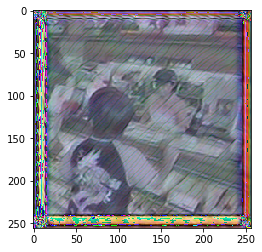

[epoch: 1 iteration:35600] Style Loss: 1067.553467 Content Loss: 2567.022217 TV LOSS : 18.704933
[epoch: 1 iteration:35700] Style Loss: 1259.531860 Content Loss: 3143.072266 TV LOSS : 18.970135
[epoch: 1 iteration:35800] Style Loss: 1075.145508 Content Loss: 3081.949951 TV LOSS : 18.905228
[epoch: 1 iteration:35900] Style Loss: 1030.808716 Content Loss: 2638.008789 TV LOSS : 18.442106
[epoch: 1 iteration:36000] Style Loss: 1046.234497 Content Loss: 2534.179199 TV LOSS : 18.826931
checkpoint is saved !


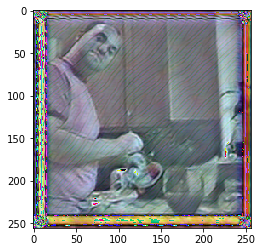

[epoch: 1 iteration:36100] Style Loss: 1004.360413 Content Loss: 2888.349121 TV LOSS : 18.525574
[epoch: 1 iteration:36200] Style Loss: 1047.185913 Content Loss: 2768.750488 TV LOSS : 19.378838
[epoch: 2 iteration:36300] Style Loss: 1002.692627 Content Loss: 2867.906250 TV LOSS : 18.855869
[epoch: 2 iteration:36400] Style Loss: 994.533447 Content Loss: 2598.963623 TV LOSS : 18.652435
[epoch: 2 iteration:36500] Style Loss: 959.679138 Content Loss: 2421.084473 TV LOSS : 18.849003
checkpoint is saved !


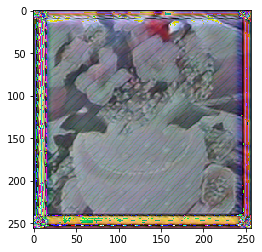

[epoch: 2 iteration:36600] Style Loss: 1070.799927 Content Loss: 2586.986084 TV LOSS : 18.231947
[epoch: 2 iteration:36700] Style Loss: 909.695374 Content Loss: 2842.564209 TV LOSS : 18.795389
[epoch: 2 iteration:36800] Style Loss: 929.658264 Content Loss: 2618.999756 TV LOSS : 19.284859
[epoch: 2 iteration:36900] Style Loss: 1258.735840 Content Loss: 2421.950439 TV LOSS : 18.677588
[epoch: 2 iteration:37000] Style Loss: 958.181091 Content Loss: 2785.894043 TV LOSS : 19.144032
checkpoint is saved !


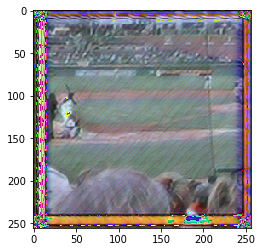

[epoch: 2 iteration:37100] Style Loss: 1116.930908 Content Loss: 2806.388184 TV LOSS : 17.901550
[epoch: 2 iteration:37200] Style Loss: 921.455505 Content Loss: 2502.665039 TV LOSS : 18.261414
[epoch: 2 iteration:37300] Style Loss: 866.350708 Content Loss: 2578.239990 TV LOSS : 18.408838
[epoch: 2 iteration:37400] Style Loss: 842.241638 Content Loss: 2692.601074 TV LOSS : 18.671814
[epoch: 2 iteration:37500] Style Loss: 911.843933 Content Loss: 2649.086670 TV LOSS : 19.624104
checkpoint is saved !


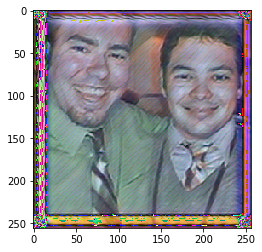

[epoch: 3 iteration:37600] Style Loss: 882.598755 Content Loss: 2593.329590 TV LOSS : 18.612144
[epoch: 3 iteration:37700] Style Loss: 869.850220 Content Loss: 2992.813477 TV LOSS : 19.171410
[epoch: 3 iteration:37800] Style Loss: 769.225830 Content Loss: 2622.585938 TV LOSS : 18.968887
[epoch: 3 iteration:37900] Style Loss: 867.143738 Content Loss: 2529.535156 TV LOSS : 18.289690
[epoch: 3 iteration:38000] Style Loss: 923.893677 Content Loss: 2929.580322 TV LOSS : 18.269316
checkpoint is saved !


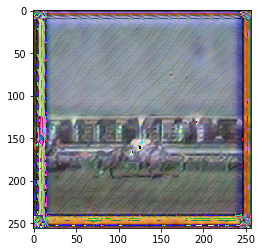

[epoch: 3 iteration:38100] Style Loss: 845.167114 Content Loss: 2842.421387 TV LOSS : 18.916021
[epoch: 3 iteration:38200] Style Loss: 768.789612 Content Loss: 2940.150391 TV LOSS : 19.052176
[epoch: 3 iteration:38300] Style Loss: 914.995789 Content Loss: 2548.963623 TV LOSS : 18.612593
[epoch: 3 iteration:38400] Style Loss: 825.511841 Content Loss: 2585.572998 TV LOSS : 18.396154
[epoch: 3 iteration:38500] Style Loss: 779.885254 Content Loss: 3863.664307 TV LOSS : 18.258043
checkpoint is saved !


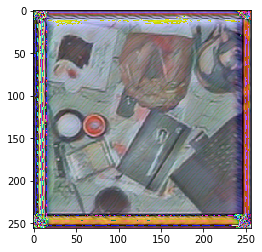

[epoch: 3 iteration:38600] Style Loss: 739.796082 Content Loss: 2539.381348 TV LOSS : 19.086317
[epoch: 3 iteration:38700] Style Loss: 793.256958 Content Loss: 2559.401367 TV LOSS : 19.370600
[epoch: 4 iteration:38800] Style Loss: 919.826172 Content Loss: 2543.176758 TV LOSS : 18.189743
[epoch: 4 iteration:38900] Style Loss: 791.263428 Content Loss: 2646.215332 TV LOSS : 18.560745
[epoch: 4 iteration:39000] Style Loss: 778.728455 Content Loss: 2445.904541 TV LOSS : 18.595798
checkpoint is saved !


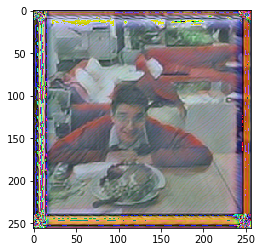

[epoch: 4 iteration:39100] Style Loss: 1228.766113 Content Loss: 2434.127930 TV LOSS : 17.537161
[epoch: 4 iteration:39200] Style Loss: 1021.407227 Content Loss: 2554.443848 TV LOSS : 18.265497
[epoch: 4 iteration:39300] Style Loss: 912.036682 Content Loss: 2730.052490 TV LOSS : 19.280571
[epoch: 4 iteration:39400] Style Loss: 1053.858398 Content Loss: 3032.255859 TV LOSS : 17.813299
[epoch: 4 iteration:39500] Style Loss: 919.156738 Content Loss: 3154.385010 TV LOSS : 19.651066
checkpoint is saved !


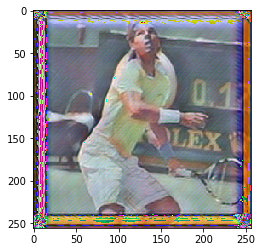

[epoch: 4 iteration:39600] Style Loss: 711.316345 Content Loss: 2407.487305 TV LOSS : 18.336107
[epoch: 4 iteration:39700] Style Loss: 855.906860 Content Loss: 2659.706299 TV LOSS : 18.418919
[epoch: 4 iteration:39800] Style Loss: 654.693420 Content Loss: 3016.295654 TV LOSS : 18.169043
[epoch: 4 iteration:39900] Style Loss: 701.019592 Content Loss: 2433.154785 TV LOSS : 18.734852
[epoch: 4 iteration:40000] Style Loss: 725.500610 Content Loss: 2494.675781 TV LOSS : 18.138926
checkpoint is saved !


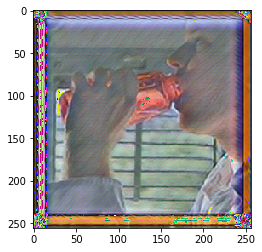

[epoch: 5 iteration:40100] Style Loss: 748.718994 Content Loss: 2850.726318 TV LOSS : 18.949951
[epoch: 5 iteration:40200] Style Loss: 623.144653 Content Loss: 2600.364258 TV LOSS : 18.330492
[epoch: 5 iteration:40300] Style Loss: 647.379272 Content Loss: 2459.601318 TV LOSS : 18.565739
[epoch: 5 iteration:40400] Style Loss: 640.647095 Content Loss: 2302.634277 TV LOSS : 18.500767
[epoch: 5 iteration:40500] Style Loss: 721.619080 Content Loss: 2428.361816 TV LOSS : 18.887621
checkpoint is saved !


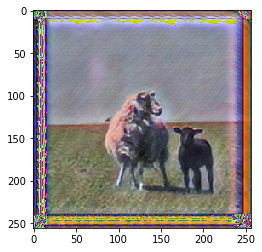

[epoch: 5 iteration:40600] Style Loss: 836.168457 Content Loss: 2806.402588 TV LOSS : 17.815432
[epoch: 5 iteration:40700] Style Loss: 735.203796 Content Loss: 2456.721191 TV LOSS : 18.764122
[epoch: 5 iteration:40800] Style Loss: 698.621460 Content Loss: 2607.536377 TV LOSS : 18.282841
[epoch: 5 iteration:40900] Style Loss: 675.168823 Content Loss: 2504.844971 TV LOSS : 18.712957
[epoch: 5 iteration:41000] Style Loss: 629.518005 Content Loss: 2326.082520 TV LOSS : 18.670958
checkpoint is saved !


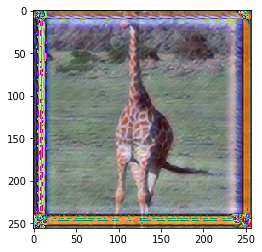

[epoch: 5 iteration:41100] Style Loss: 815.330566 Content Loss: 2440.806641 TV LOSS : 17.938658
[epoch: 5 iteration:41200] Style Loss: 671.455566 Content Loss: 2517.362305 TV LOSS : 18.233681
[epoch: 6 iteration:41300] Style Loss: 1074.480469 Content Loss: 2554.305664 TV LOSS : 17.500189
[epoch: 6 iteration:41400] Style Loss: 677.424377 Content Loss: 2634.988281 TV LOSS : 18.105350
[epoch: 6 iteration:41500] Style Loss: 666.350464 Content Loss: 2840.165527 TV LOSS : 18.493982
checkpoint is saved !


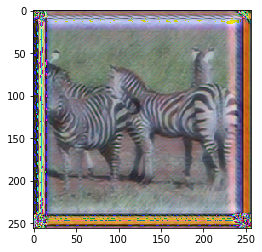

[epoch: 6 iteration:41600] Style Loss: 686.490479 Content Loss: 2349.867188 TV LOSS : 19.111700
[epoch: 6 iteration:41700] Style Loss: 679.275330 Content Loss: 2426.608887 TV LOSS : 18.002636
[epoch: 6 iteration:41800] Style Loss: 672.330872 Content Loss: 2349.911865 TV LOSS : 18.046391
[epoch: 6 iteration:41900] Style Loss: 697.331360 Content Loss: 2310.609375 TV LOSS : 18.230837
[epoch: 6 iteration:42000] Style Loss: 652.630310 Content Loss: 2447.908691 TV LOSS : 18.849951
checkpoint is saved !


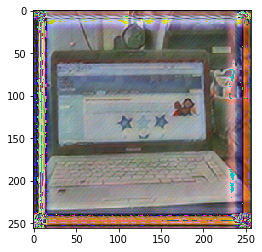

[epoch: 6 iteration:42100] Style Loss: 639.212280 Content Loss: 2945.456055 TV LOSS : 18.640873
[epoch: 6 iteration:42200] Style Loss: 1713.798706 Content Loss: 2601.498535 TV LOSS : 18.330872
[epoch: 6 iteration:42300] Style Loss: 677.079346 Content Loss: 2304.354492 TV LOSS : 18.495798
[epoch: 6 iteration:42400] Style Loss: 584.983643 Content Loss: 2349.522705 TV LOSS : 18.454571
[epoch: 6 iteration:42500] Style Loss: 610.714172 Content Loss: 2547.497070 TV LOSS : 18.315041
checkpoint is saved !


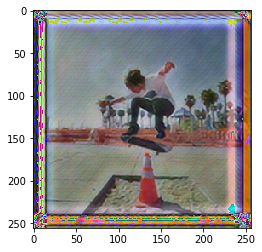

[epoch: 7 iteration:42600] Style Loss: 615.858093 Content Loss: 2616.786133 TV LOSS : 18.679922
[epoch: 7 iteration:42700] Style Loss: 632.953918 Content Loss: 2406.679199 TV LOSS : 18.277418
[epoch: 7 iteration:42800] Style Loss: 690.978210 Content Loss: 2422.793701 TV LOSS : 17.829821
[epoch: 7 iteration:42900] Style Loss: 612.119141 Content Loss: 2564.954590 TV LOSS : 18.638290
[epoch: 7 iteration:43000] Style Loss: 676.461060 Content Loss: 2556.390381 TV LOSS : 18.908548
checkpoint is saved !


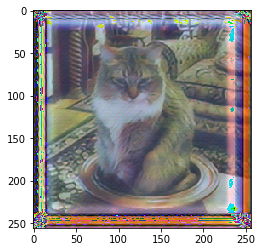

[epoch: 7 iteration:43100] Style Loss: 703.521973 Content Loss: 2527.254883 TV LOSS : 18.071550
[epoch: 7 iteration:43200] Style Loss: 663.557983 Content Loss: 2726.390381 TV LOSS : 17.873253
[epoch: 7 iteration:43300] Style Loss: 626.337646 Content Loss: 2440.401367 TV LOSS : 18.410187
[epoch: 7 iteration:43400] Style Loss: 593.993042 Content Loss: 2287.303223 TV LOSS : 18.749435
[epoch: 7 iteration:43500] Style Loss: 586.888306 Content Loss: 2422.755127 TV LOSS : 18.000900
checkpoint is saved !


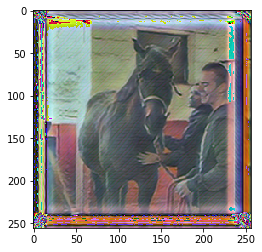

[epoch: 7 iteration:43600] Style Loss: 777.451599 Content Loss: 2470.903320 TV LOSS : 18.473307
[epoch: 7 iteration:43700] Style Loss: 589.677856 Content Loss: 2478.969482 TV LOSS : 18.573660
[epoch: 8 iteration:43800] Style Loss: 674.429932 Content Loss: 2368.722168 TV LOSS : 17.728983
[epoch: 8 iteration:43900] Style Loss: 620.592102 Content Loss: 2517.565430 TV LOSS : 18.550268
[epoch: 8 iteration:44000] Style Loss: 604.010071 Content Loss: 2423.790283 TV LOSS : 17.894373
checkpoint is saved !


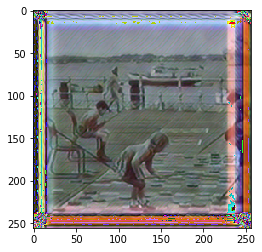

[epoch: 8 iteration:44100] Style Loss: 629.641418 Content Loss: 2221.356689 TV LOSS : 17.872568
[epoch: 8 iteration:44200] Style Loss: 599.612915 Content Loss: 2641.492676 TV LOSS : 18.394545
[epoch: 8 iteration:44300] Style Loss: 584.522705 Content Loss: 2709.240967 TV LOSS : 18.210478
[epoch: 8 iteration:44400] Style Loss: 652.293030 Content Loss: 2515.943115 TV LOSS : 17.504246
[epoch: 8 iteration:44500] Style Loss: 630.139832 Content Loss: 2840.875732 TV LOSS : 17.977871
checkpoint is saved !


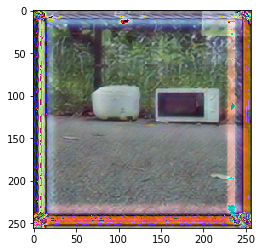

[epoch: 8 iteration:44600] Style Loss: 557.143127 Content Loss: 2350.170166 TV LOSS : 17.984516
[epoch: 8 iteration:44700] Style Loss: 594.593689 Content Loss: 2778.040771 TV LOSS : 18.073540
[epoch: 8 iteration:44800] Style Loss: 681.869690 Content Loss: 2365.139404 TV LOSS : 18.419239
[epoch: 8 iteration:44900] Style Loss: 549.934326 Content Loss: 2427.212158 TV LOSS : 17.973055
[epoch: 8 iteration:45000] Style Loss: 651.062317 Content Loss: 2270.578857 TV LOSS : 17.528582
checkpoint is saved !


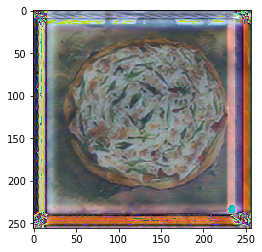

[epoch: 9 iteration:45100] Style Loss: 664.349548 Content Loss: 2327.677979 TV LOSS : 17.859186
[epoch: 9 iteration:45200] Style Loss: 585.914551 Content Loss: 2183.546387 TV LOSS : 17.967052
[epoch: 9 iteration:45300] Style Loss: 576.147278 Content Loss: 2319.264648 TV LOSS : 17.632879
[epoch: 9 iteration:45400] Style Loss: 554.296692 Content Loss: 2372.405518 TV LOSS : 18.229595
[epoch: 9 iteration:45500] Style Loss: 596.453491 Content Loss: 2164.702881 TV LOSS : 17.501511
checkpoint is saved !


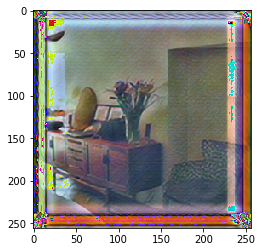

[epoch: 9 iteration:45600] Style Loss: 587.963257 Content Loss: 2741.989258 TV LOSS : 17.988424
[epoch: 9 iteration:45700] Style Loss: 557.057434 Content Loss: 2519.626709 TV LOSS : 18.315554
[epoch: 9 iteration:45800] Style Loss: 599.954834 Content Loss: 2195.527100 TV LOSS : 17.991508
[epoch: 9 iteration:45900] Style Loss: 627.433472 Content Loss: 2406.770020 TV LOSS : 17.717045
[epoch: 9 iteration:46000] Style Loss: 622.765381 Content Loss: 2443.303955 TV LOSS : 18.147284
checkpoint is saved !


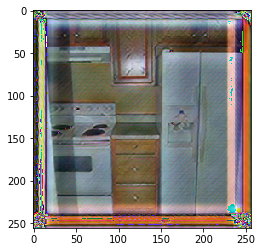

[epoch: 9 iteration:46100] Style Loss: 606.068909 Content Loss: 2239.264648 TV LOSS : 17.942846
[epoch: 9 iteration:46200] Style Loss: 888.763916 Content Loss: 2401.091309 TV LOSS : 17.572321
[epoch: 10 iteration:46300] Style Loss: 554.150574 Content Loss: 2400.780029 TV LOSS : 17.873306
[epoch: 10 iteration:46400] Style Loss: 584.588318 Content Loss: 2435.625488 TV LOSS : 17.907490
[epoch: 10 iteration:46500] Style Loss: 555.489136 Content Loss: 2405.831299 TV LOSS : 18.282330
checkpoint is saved !


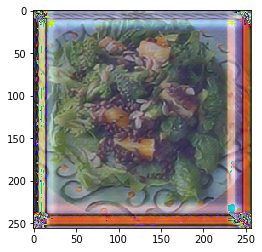

[epoch: 10 iteration:46600] Style Loss: 588.013611 Content Loss: 2559.064453 TV LOSS : 17.780659
[epoch: 10 iteration:46700] Style Loss: 600.343994 Content Loss: 2419.974121 TV LOSS : 17.742439
[epoch: 10 iteration:46800] Style Loss: 692.885925 Content Loss: 3107.162354 TV LOSS : 17.768217
[epoch: 10 iteration:46900] Style Loss: 713.806885 Content Loss: 2530.327637 TV LOSS : 17.726418
[epoch: 10 iteration:47000] Style Loss: 691.429443 Content Loss: 2276.260742 TV LOSS : 18.170856
checkpoint is saved !


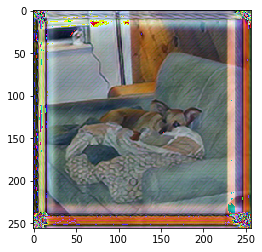

[epoch: 10 iteration:47100] Style Loss: 640.132874 Content Loss: 2367.132080 TV LOSS : 17.706638
[epoch: 10 iteration:47200] Style Loss: 601.902161 Content Loss: 2335.454834 TV LOSS : 17.628536
[epoch: 10 iteration:47300] Style Loss: 563.379150 Content Loss: 2617.060547 TV LOSS : 17.892401
[epoch: 10 iteration:47400] Style Loss: 591.383972 Content Loss: 2338.734131 TV LOSS : 17.952087
[epoch: 10 iteration:47500] Style Loss: 576.165283 Content Loss: 2236.083496 TV LOSS : 17.673399
checkpoint is saved !


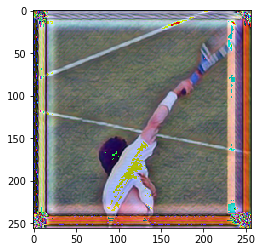

[epoch: 11 iteration:47600] Style Loss: 591.382751 Content Loss: 2308.774170 TV LOSS : 17.566547
[epoch: 11 iteration:47700] Style Loss: 610.733459 Content Loss: 2368.657715 TV LOSS : 18.162628
[epoch: 11 iteration:47800] Style Loss: 543.422607 Content Loss: 2519.422852 TV LOSS : 17.889668
[epoch: 11 iteration:47900] Style Loss: 729.768677 Content Loss: 2129.482422 TV LOSS : 18.409769
[epoch: 11 iteration:48000] Style Loss: 589.647278 Content Loss: 2355.294189 TV LOSS : 18.327904
checkpoint is saved !


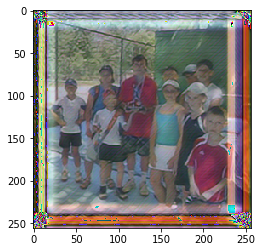

[epoch: 11 iteration:48100] Style Loss: 544.624268 Content Loss: 2204.619141 TV LOSS : 18.350285
[epoch: 11 iteration:48200] Style Loss: 601.415222 Content Loss: 2300.107910 TV LOSS : 18.328138
[epoch: 11 iteration:48300] Style Loss: 625.895142 Content Loss: 2316.406738 TV LOSS : 18.296183
[epoch: 11 iteration:48400] Style Loss: 589.161072 Content Loss: 2206.955078 TV LOSS : 18.574749
[epoch: 11 iteration:48500] Style Loss: 587.835754 Content Loss: 2497.552246 TV LOSS : 17.997786
checkpoint is saved !


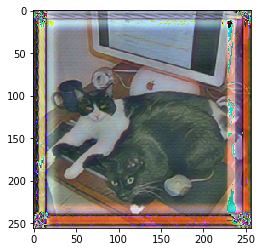

[epoch: 11 iteration:48600] Style Loss: 564.862793 Content Loss: 2260.570068 TV LOSS : 18.850643
[epoch: 11 iteration:48700] Style Loss: 701.608887 Content Loss: 2187.713379 TV LOSS : 17.952045
[epoch: 12 iteration:48800] Style Loss: 813.146301 Content Loss: 2437.863281 TV LOSS : 18.412600
[epoch: 12 iteration:48900] Style Loss: 576.126099 Content Loss: 2417.754395 TV LOSS : 18.499405
[epoch: 12 iteration:49000] Style Loss: 654.393005 Content Loss: 2330.816895 TV LOSS : 17.777372
checkpoint is saved !


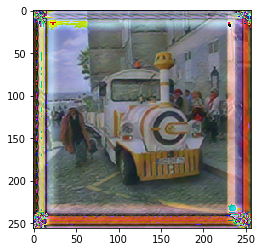

[epoch: 12 iteration:49100] Style Loss: 574.804382 Content Loss: 2236.804443 TV LOSS : 18.179729


In [0]:
torch.manual_seed(42)

# initialization
transfer_net = TransformerNet().to(device)
optimizer = optim.Adam(transfer_net.parameters(),lr = 1e-3)

#vgg loss network 
vgg, relu_layers, style_losses = make_model(cnn2, content_layers, style_layers)
tv_loss = TotalVariationLoss()
model = nn.Sequential(tv_loss, *vgg)

#initialization
it = 35000
num_epoch = 15
train_losses = []

#load checkpoint if it exists
ckpt_dir = os.path.join(gdrive_root, '2/checkpoints_7')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

if os.path.exists(os.path.join(ckpt_dir, 'it_35000.pt')):
  ckpt = torch.load(os.path.join(ckpt_dir, 'it_35000.pt'))
  print('checkpoint is loaded !')
  try:
    transfer_net.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optim'])
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')

for epoch in range(num_epoch):

  # do not modify vgg 
  #vgg.eval()
  for inputs,labels in train_loader:
    it += 1

    #train step 
    transfer_net.train()
    
    # load data to the GPU.
    inputs = inputs.to(device)

    #output img
    output = transfer_net(inputs)

    # loss NETWORK
    vgg(inputs)
    content = [layer.feature for i, layer in enumerate(relu_layers)]
    model(output)
    outputs = [layer.feature for i, layer in enumerate(relu_layers)]

    optimizer.zero_grad()

    style_score = 0
    content_score = 0
    for i,sl  in enumerate(style_losses):
      style_score += style_weights[i] * sl.loss
    #content_score = CONTENT_WEIGHTS[0] * F.mse_loss(outputs[0], content[0])
    content_score = content_weight * F.mse_loss(outputs[0], content[0])
    tv_score = TV_WEIGHT * tv_loss.loss

    loss = style_score + content_score + tv_score
    loss.backward()

    optimizer.step()

    # print the log
    if it % 100 == 0:
      print(f"[epoch: {epoch+1} iteration:{it}] Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f} TV LOSS : {tv_score.item():4f}")   
    train_losses.append(loss)  

    transfer_net.eval()
    transfer_net.cpu()

    # save the checkpoint
    if it % 500 == 0:
      ckpt = {'model':transfer_net.state_dict()
      ,'optim': optimizer.state_dict()}
      name = "it_"+str(it)+".pt"
      torch.save(ckpt, os.path.join(ckpt_dir, name))
      print('checkpoint is saved !')

      plt.figure()
      imshow(output[0])
      plt.show()
      
    transfer_net.to(device)

#plot the loss graph of the transfer_net
plt.plot(train_losses, label='train loss')
plt.legend()

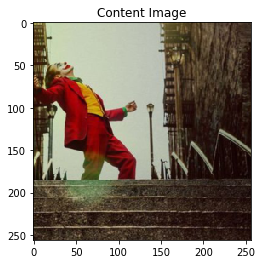

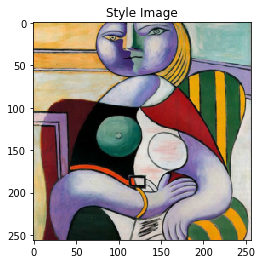

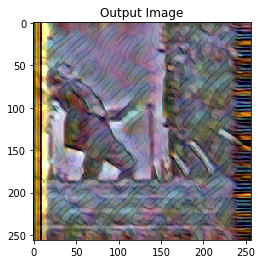

In [0]:
######################################################################################################

#Load the checkpoint and conduct test. 

def inference(ckpt_path, content_img):
  with torch.no_grad():
    # do something
    model = TransformerNet()
    ckpt = torch.load(ckpt_path, map_location = device)
    model.load_state_dict(ckpt['model'])

    model.to(device)

    output_img = model(content_img).cpu()

    output_img.data.clamp_(0, 1)

  return output_img

content_img = image_loader("./content.jpg", batch_size=BATCH_SIZE)
ckpt_dir = os.path.join(gdrive_root, '2/checkpoints_7')
output_img3 = inference(os.path.join(ckpt_dir, 'it_17000.pt'), content_img)

plt.figure()
imshow(content_img[0], title='Content Image')

plt.figure()
imshow(style_img[0], title='Style Image')

plt.figure()
imshow(output_img3[0], title='Output Image', save=gdrive_data+'/synthesized.jpg')

plt.show()